Student Name: Marcos David Madrigal Albores

Student Number: 1004731347

In [45]:
%%shell
jupyter nbconvert --to html /content/Lab_5_Spam_Detection_final.ipynb

[NbConvertApp] Converting notebook /content/Lab_5_Spam_Detection_final.ipynb to html
[NbConvertApp] Writing 436638 bytes to /content/Lab_5_Spam_Detection_final.html


# Lab 5: Spam Detection

**Deadline**: Monday, March 15, 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Gautam Dawar <gautam.dawar@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1cVUceT9DHosoeEs9kozg7p80pcTQNndE?usp=sharing

In [2]:
!git clone https://github.com/Marneus981/Aps360stuff.git

Cloning into 'Aps360stuff'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6227 (delta 1), reused 4 (delta 0), pack-reused 6218
Receiving objects: 100% (6227/6227), 305.29 MiB | 38.57 MiB/s, done.
Resolving deltas: 100% (342/342), done.
Checking out files: 100% (6335/6335), done.


In [3]:
path_to_folder = "/content/Aps360stuff/smsspamcollection"
path_to_data = "/content/Aps360stuff/smsspamcollection/SMSSpamCollection"

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
torch.manual_seed(981)

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [5]:
counter_h = 0
counter_s = 0
for line in open(path_to_data):
    if ((counter_s == 1)&(counter_h == 1)):
      break
    if ((line[0] == 'h')&(counter_h == 0)):
      counter_h += 1 
      print(line)
    elif ((line[0] == 's')&(counter_s == 0)):
      counter_s += 1 
      print(line)

#The label for non-spam is ham, the label for spam is spam

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [6]:
counter_h = 0
counter_s = 0
for line in open(path_to_data):
  if line[0] == 'h':
    counter_h += 1
  elif line[0] == 's':
    counter_s += 1

print("Ham: {0} Spam: {1}".format(counter_h,counter_s))

Ham: 4827 Spam: 747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [7]:
#Advantages
#1.- Less characters than words, so less storage requirements
#2.- Expanding on the first point, theres only so many characters, while there might be so pretty
#obscure or niche words
#Disadvantages
#1.- Words convey meaning, characters do not. So while model has to learn th relationship between a couple of words, in 
#this approach it has to learn the realtionships between several characters
#2.- Per message there are generally more characters than words, so inputs to the model will be much longer (leading to more computation requirements as well)

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [8]:
import torchtext.legacy as torchtext
#import torchtext
#As os 0.9.0
#torchtext.data.Pipeline -> torchtext.legacy.data.Pipeline
#torchtext.data.Batch -> torchtext.legacy.data.Batch
#torchtext.data.Example -> torchtext.legacy.data.Example
#torchtext.data.Field -> torchtext.legacy.data.Field
#torchtext.data.Iterator -> torchtext.legacy.data.Iterator
#torchtext.data.Dataset -> torchtext.legacy.data.Dataset
text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(path_to_data, # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [9]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

#Answer: If the model is inbalanced it can easily bias itself towards certain
#labels and charcateristics to achieve high accuracy, in short it gets lazy(
#this model is not learning at all).

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [10]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#Mapping of character in training set -> numerical identifier
#text_field.vocab.itos
#List of characters indexed by their corresponding numerical identifiers given
#by the above mapping

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [11]:
#<unk>
#These are unknown/not frequent enough characters (such that it was removed
#from the dictionary)
#<pad>
#Padding to make sure the lenght of SMSs stays uniform across a batch

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [12]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs  
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs                                         

#Take a look at 10 batches in train_iter. 
#What is the maximum length of the input sequence in each batch? 
#How many <pad> tokens are used in each of the 10 batches?

In [13]:
padding = [0]*10
maxlen = [0]*10
i = 0
for batch in train_iter:
  if i == 10 : #Only first 10 batches
    break
  for sms in batch.sms[0]:
    for token in sms:
      if token == text_field.vocab.stoi['<pad>']:
        padding[i] = padding[i] + 1  #Increase padding
    if len(sms) > maxlen[i]: #Update maxlen per batch
      maxlen[i] = len(sms)
  i = i + 1
    
print('Maximum Lenghts per Batch {}'.format(maxlen))
print('Padding per Batch {}'.format(padding))
#print('Example sms {}'.format(batch.sms))
#print('Example label {}'.format(batch.label))

Maximum Lenghts per Batch [73, 36, 158, 75, 61, 159, 175, 34, 155, 135]
Padding per Batch [27, 16, 0, 32, 50, 0, 196, 27, 0, 35]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [14]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [24]:
#Code modified form tutorials 5 and 6
class CatRNN(nn.Module):
    def __init__(self, input_size, hidden_size, pooling = 0):
        self.name = "CatRNN"
        super(CatRNN, self).__init__()
        self.pooling = pooling
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ident = torch.eye(input_size)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        if pooling == 2: #Change output pooling in response to pooling hyperparameter
          self.fc = nn.Linear(hidden_size*2, 2) #In case we have to concat
        else:
          self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):

        x_size = x.size(0) #Get size of x for h0
        h0 = torch.zeros(1, x_size, self.hidden_size) #Hidden 0
        x, _ = self.rnn(self.ident[x], h0)
        if self.pooling == 1: #Change pooling
          x = torch.max(x, dim=1)[0] #Max
          x = self.fc(x)
        elif self.pooling == 2:
          x = torch.cat([torch.max(x, dim=1)[0], torch.mean(x, dim=1)], dim=1)#Concat max and avg
          x = self.fc(x)
        else:
          x = self.fc(x[:,-1,:]) #Normal
        return x

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [25]:
#Code modified from tutorial 5
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_loader = data #Modified
    correct, total = 0, 0
    for sms, labels in data_loader:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [26]:
import matplotlib.pyplot as plt # plotting

In [27]:
for sms,labels in train_iter:
  print(sms[0].shape)
  #print(labels[0].shape)
  #print(labels[0])

torch.Size([32, 52])
torch.Size([32, 156])
torch.Size([32, 142])
torch.Size([32, 160])
torch.Size([32, 126])
torch.Size([32, 63])
torch.Size([32, 91])
torch.Size([32, 146])
torch.Size([32, 152])
torch.Size([32, 139])
torch.Size([32, 47])
torch.Size([32, 204])
torch.Size([32, 78])
torch.Size([32, 133])
torch.Size([32, 114])
torch.Size([32, 95])
torch.Size([32, 145])
torch.Size([32, 33])
torch.Size([32, 151])
torch.Size([32, 37])
torch.Size([32, 25])
torch.Size([32, 160])
torch.Size([32, 22])
torch.Size([32, 158])
torch.Size([32, 101])
torch.Size([32, 23])
torch.Size([32, 154])
torch.Size([32, 66])
torch.Size([32, 135])
torch.Size([32, 116])
torch.Size([32, 30])
torch.Size([32, 152])
torch.Size([32, 156])
torch.Size([32, 155])
torch.Size([32, 166])
torch.Size([32, 54])
torch.Size([32, 161])
torch.Size([32, 81])
torch.Size([32, 48])
torch.Size([32, 148])
torch.Size([32, 138])
torch.Size([32, 41])
torch.Size([32, 132])
torch.Size([32, 122])
torch.Size([32, 141])
torch.Size([32, 158])
torch

In [28]:
#Code modified from tutorial 5
def train_myRNN(model, train_dta, valid_dta, num_epochs=5, learning_rate=1e-5, plot_q=True):
    #To avoid funky stuff and extra hassle
    train_loader = train_dta
    valid_loader = valid_dta
    ####################
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    tr_losses, val_losses, train_acc, valid_acc = [], [], [], []
    epochs_ = 0
    #Modifications start here
    for epoch in range(num_epochs):
        for sms, labels in train_loader: 
          
          
          pred = model(sms[0])
          tr_loss = criterion(pred.float(), labels)
          tr_loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          #print("Its Working! 0")
        
        for sms, labels in valid_loader:
          pred = model(sms[0])
          val_loss = criterion(pred.float(), labels)
          #print("Its Working! 1")

        val_losses.append(float(val_loss))
        tr_losses.append(float(tr_loss))
        epochs_ = epochs_ +1
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Train Loss %f;Validation Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, tr_loss,val_loss, train_acc[-1], valid_acc[-1]))
    
    epochs = np.arange(1, epochs_ + 1)
    # plotting
    if plot_q == True:
      
      print("Epochs: {0},Learning Rate: {1}".format(num_epochs, learning_rate))
      plt.title("Training Curve")
      plt.plot(epochs,tr_losses, label="Train")
      plt.plot(epochs,val_losses, label="Validation")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

      plt.title("Training Curve")
      plt.plot(epochs, train_acc, label="Train")
      plt.plot(epochs, valid_acc, label="Validation")
      plt.xlabel("Epoch")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()

    print("Final Training Loss: {}".format(tr_losses[-1]))
    print("Final Validation Loss: {}".format(val_losses[-1]))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

Epoch 1; Train Loss 0.711434;Validation Loss 0.693264; Train Acc 0.616105; Val Acc 0.287892
Epoch 2; Train Loss 0.441635;Validation Loss 0.311621; Train Acc 0.901233; Val Acc 0.939910
Epoch 3; Train Loss 0.286891;Validation Loss 0.184495; Train Acc 0.922104; Val Acc 0.939910
Epoch 4; Train Loss 0.680439;Validation Loss 0.206534; Train Acc 0.937223; Val Acc 0.936323
Epoch 5; Train Loss 0.229532;Validation Loss 0.080868; Train Acc 0.931800; Val Acc 0.950673
Epochs: 5,Learning Rate: 0.0001


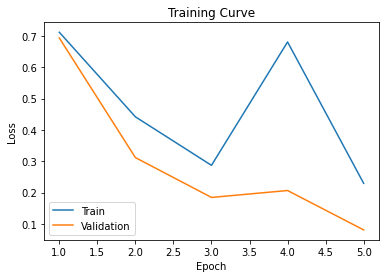

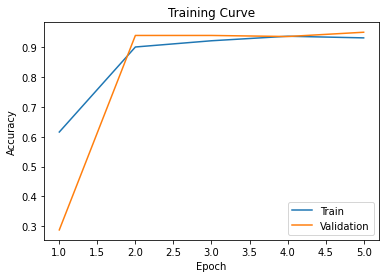

Final Training Loss: 0.22953228652477264
Final Validation Loss: 0.08086812496185303
Final Training Accuracy: 0.9317995069843878
Final Validation Accuracy: 0.9506726457399103


In [20]:
#Default attributes for network
vocab_len =len(text_field.vocab.itos)
neuron_number = len(text_field.vocab.itos)
num_epochs = 5
pooling = 0
lr = 1e-4
#Defaulted training

zerothRNN = CatRNN(input_size = vocab_len, hidden_size = neuron_number, pooling = pooling) 

train_myRNN(zerothRNN ,train_iter,valid_iter,num_epochs=num_epochs,learning_rate=lr, plot_q = True)


In [29]:
#Potential Hyperparameter Values
neuron_number_l = [vocab_len,200]
num_epochs_l = [5,10]
pooling_l = [0,1,2]
lr_l = [1e-4,1e-5]
#Hyperparameter tuning
i = 0
for neuron_no in neuron_number_l:
  for epoch_no in num_epochs_l:
    for lr_no in lr_l:
      for pooling_setting in pooling_l:
        print("Model {} Neurons {} Epochs {} Learning Rate {} Pooling Setting {}".format(i,neuron_no,epoch_no,lr_no,pooling_setting))
        trialRNN = CatRNN(input_size = vocab_len, hidden_size = neuron_no, pooling = pooling_setting) 
        train_myRNN(trialRNN ,train_iter,valid_iter,num_epochs=epoch_no,learning_rate=lr_no, plot_q = False)
        i = i+1

Model 0 Neurons 114 Epochs 5 Learning Rate 0.0001 Pooling Setting 0
Epoch 1; Train Loss 0.629239;Validation Loss 0.689220; Train Acc 0.713722; Val Acc 0.645740
Epoch 2; Train Loss 0.661143;Validation Loss 0.735539; Train Acc 0.738044; Val Acc 0.561435
Epoch 3; Train Loss 0.551910;Validation Loss 1.220374; Train Acc 0.553164; Val Acc 0.199103
Epoch 4; Train Loss 0.235761;Validation Loss 0.457840; Train Acc 0.857518; Val Acc 0.859193
Epoch 5; Train Loss 0.335043;Validation Loss 0.242361; Train Acc 0.901561; Val Acc 0.935426
Final Training Loss: 0.335042804479599
Final Validation Loss: 0.242361381649971
Final Training Accuracy: 0.9015612161051767
Final Validation Accuracy: 0.9354260089686098
Model 1 Neurons 114 Epochs 5 Learning Rate 0.0001 Pooling Setting 1
Epoch 1; Train Loss 0.700103;Validation Loss 0.743611; Train Acc 0.525719; Val Acc 0.142601
Epoch 2; Train Loss 0.431368;Validation Loss 0.373568; Train Acc 0.917009; Val Acc 0.947982
Epoch 3; Train Loss 0.190263;Validation Loss 0.291

In [30]:
#Model 19 (counting from 0 to 23) Neurons 200 Epochs 10 Learning Rate 0.0001 Pooling Setting 1
bestRNN = CatRNN(input_size = vocab_len, hidden_size = 200, pooling = 1) #Max pooling
train_myRNN(bestRNN ,train_iter,valid_iter,num_epochs= 10,learning_rate=0.0001, plot_q = False)

Epoch 1; Train Loss 0.693887;Validation Loss 0.695739; Train Acc 0.709449; Val Acc 0.484305
Epoch 2; Train Loss 0.427741;Validation Loss 0.303742; Train Acc 0.941660; Val Acc 0.947982
Epoch 3; Train Loss 0.092595;Validation Loss 0.164530; Train Acc 0.926376; Val Acc 0.976682
Epoch 4; Train Loss 0.526404;Validation Loss 0.302320; Train Acc 0.943796; Val Acc 0.943498
Epoch 5; Train Loss 0.140813;Validation Loss 0.224647; Train Acc 0.956450; Val Acc 0.963229
Epoch 6; Train Loss 0.055365;Validation Loss 0.274999; Train Acc 0.949712; Val Acc 0.973094
Epoch 7; Train Loss 0.206673;Validation Loss 0.223310; Train Acc 0.962038; Val Acc 0.969507
Epoch 8; Train Loss 0.018968;Validation Loss 0.083099; Train Acc 0.959080; Val Acc 0.973094
Epoch 9; Train Loss 0.172697;Validation Loss 0.316467; Train Acc 0.963681; Val Acc 0.968610
Epoch 10; Train Loss 0.075936;Validation Loss 0.043830; Train Acc 0.951684; Val Acc 0.973991
Final Training Loss: 0.07593569904565811
Final Validation Loss: 0.0438299961388

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [21]:
#Hyperparameters: Pooling Method, Hidden Layer Size, Learning Rate, Epochs

#Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.

#To tune the hyperparameters I a for loop and sets of values for the hyperparameters to try out all possible combinations (24):

  #Learning Rate: I chose between 1e-4 and 1e-5 to try out my standard learning rate (which is bigger than some usual standard learning rates like 1e-5) vesus a more 
    #standard (and smaller) learning rate.
  #Pooling: I decided to go over all possible pooling forms to  try out which one gives the best performance in regards to each other when solving this 
    #problem.
  #Number of Epochs: Since during my testing the epoch number required has so far been low I am only increasing it between 5 and 10 for all models, due to the so far
    #quick convergence.
  #Hidden layer size/Neuron number: I decided to tune between the standard vocab size and an almost double number (200) to see the computational impact of such endeavours.

#Best validation accuracy: 0.9748878923766816 for model 19 (0.9739910313901345 when reproduced)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [33]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [34]:
print("False negative rate {}.".format(1 - get_accuracy(bestRNN, valid_spam_iter)))
print("False positive rate {}.".format(1 - get_accuracy(bestRNN, valid_nospam_iter)))


False negative rate 0.08805031446540879.
False positive rate 0.014644351464435101.


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [22]:
#Impact of False Positive: If a sms that isnt spam gets put into spam the user could lose potentially important information for them.
#Impact of False Negative: If a sms that is spam doesnt get put into spam the user's experience would be compromised because they could find it hard to discern them amongst
#important messages at first glance, therefore making it annoying to browse through their mailbox and delete the spam message themselves.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [35]:
print("Final Test Accuracy {}.".format(get_accuracy(bestRNN, test_iter)))

Final Test Accuracy 0.9748653500897666.


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [36]:
#Copied from above (when we did the validation case) and barely modified
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [37]:
print("False negative rate {}.".format(1 - get_accuracy(bestRNN, test_spam_iter)))
print("False positive rate {}.".format(1 - get_accuracy(bestRNN, test_nospam_iter)))

False negative rate 0.1145038167938931.
False positive rate 0.01322482197355035.


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [42]:
msg = "machine learning is sooo cool!"
msg_tk = []
for char in msg:
  msg_tk.append(torch.tensor(text_field.vocab.stoi[char]))
msg_tk_f = torch.stack(msg_tk)
msg_tk_f.unsqueeze_(0)
print("Probability msg is spam: ")
print(F.softmax(bestRNN(msg_tk_f), dim=1)[0][1].item())

Probability msg is spam: 
0.04967055097222328


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [43]:
#We could use a simple algorithm with two databases to build a baseline model;
#this model would essentially do the following:
#1.-Load in a database of suspicious words, and have a database (empty so far)
#of suspicious email addresses/phone numbers
#2.-First, it would search its suspicious address/phone number database to
#automatically label a message base on its source (on first iteration this 
#wouldnt be of any use since it builds up its database as it encounters spam).
#Then it would take in messages as strings of words and compare them against
#its database of suspicous words
#3.-If it finds a suspicious word (or more than a certain threshold) add
#the email address/phone number to its suspicious email/phone number database,
#this way it automatically labels as spam anything coming from said sources.
#4.-Repeat from 2 onwards for each message